In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define number of particles and get random positions (between 0 and 1) for each particle

In [2]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)

In [3]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)
# Color particles the start on either side
ixr = r[0]>0.5 #right
ixl = r[0]<=0.5 #left

Give IDs to each particle (this will come in handy later)

In [4]:
ids = torch.arange(n_particles)

In [5]:
ids

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

Plot initial configuration of particles

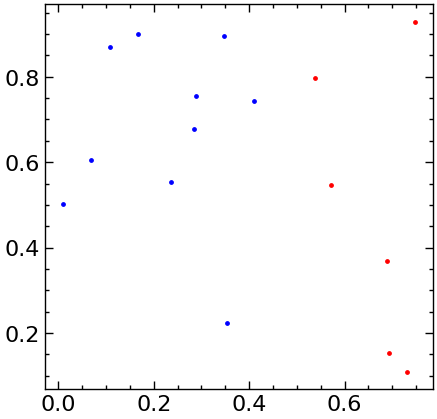

In [6]:
plt.figure(figsize=(5,5))
plt.scatter(r[0][ixr].cpu(),r[1][ixr].cpu(), color='r', s=6)
plt.scatter(r[0][ixl].cpu(),r[1][ixl].cpu(), color='b', s=6)

Obtain the initial velocities in the gas. We'll make the particles starting on the RHS move to the left at 500m/s and on the vice versa.

* **Note**: We're using the assumption that particles in a gas move at approximately 500m/s, thanks google.

In [7]:
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500

To run this simulation, we need to determine when two particles collide, and what the resulting final velocities will be.

# Part 1: Distance Between all Pairs

* To determine if two particles collide, we need to find the distance between **all pairs** of particles. If the distance is less than 2 times the radius of each particle, they collide. If there are $n$ particles, there are $n(n-1)/2$ pairs (combinatorics). To make this easier, we'll get pairs of particle IDs.

In [8]:
ids_pairs = torch.combinations(ids,2).to(device)
#ids_pairs

We can obtain distances between particles in a similar fashion

* First get the pairs of x-positions of all particles

In [9]:
x_pairs = torch.combinations(r[0],2).to(device)
x_pairs

tensor([[0.0686, 0.0096],
        [0.0686, 0.1090],
        [0.0686, 0.7318],
        [0.0686, 0.2848],
        [0.0686, 0.6931],
        [0.0686, 0.3537],
        [0.0686, 0.7479],
        [0.0686, 0.1681],
        [0.0686, 0.5387],
        [0.0686, 0.5709],
        [0.0686, 0.2896],
        [0.0686, 0.6881],
        [0.0686, 0.3468],
        [0.0686, 0.2368],
        [0.0686, 0.4103],
        [0.0096, 0.1090],
        [0.0096, 0.7318],
        [0.0096, 0.2848],
        [0.0096, 0.6931],
        [0.0096, 0.3537],
        [0.0096, 0.7479],
        [0.0096, 0.1681],
        [0.0096, 0.5387],
        [0.0096, 0.5709],
        [0.0096, 0.2896],
        [0.0096, 0.6881],
        [0.0096, 0.3468],
        [0.0096, 0.2368],
        [0.0096, 0.4103],
        [0.1090, 0.7318],
        [0.1090, 0.2848],
        [0.1090, 0.6931],
        [0.1090, 0.3537],
        [0.1090, 0.7479],
        [0.1090, 0.1681],
        [0.1090, 0.5387],
        [0.1090, 0.5709],
        [0.1090, 0.2896],
        [0.1

* Then take the difference to get $\Delta x_{ij}$ of all pairs

In [10]:
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dx_pairs

tensor([-0.0590,  0.0403,  0.6631,  0.2162,  0.6245,  0.2850,  0.6792,  0.0995,
         0.4700,  0.5022,  0.2209,  0.6194,  0.2781,  0.1681,  0.3417,  0.0993,
         0.7221,  0.2752,  0.6835,  0.3440,  0.7382,  0.1585,  0.5291,  0.5612,
         0.2799,  0.6784,  0.3371,  0.2272,  0.4007,  0.6228,  0.1759,  0.5841,
         0.2447,  0.6389,  0.0592,  0.4297,  0.4619,  0.1806,  0.5791,  0.2378,
         0.1278,  0.3014, -0.4469, -0.0387, -0.3781,  0.0161, -0.5636, -0.1931,
        -0.1609, -0.4422, -0.0437, -0.3850, -0.4950, -0.3214,  0.4083,  0.0689,
         0.4630, -0.1167,  0.2539,  0.2860,  0.0047,  0.4032,  0.0619, -0.0480,
         0.1255, -0.3394,  0.0548, -0.5250, -0.1544, -0.1223, -0.4036, -0.0050,
        -0.3464, -0.4563, -0.2828,  0.3942, -0.1855,  0.1850,  0.2172, -0.0641,
         0.3344, -0.0069, -0.1169,  0.0567, -0.5797, -0.2092, -0.1770, -0.4583,
        -0.0598, -0.4011, -0.5111, -0.3375,  0.3705,  0.4027,  0.1214,  0.5199,
         0.1786,  0.0686,  0.2422,  0.03

The total distance is just $d_{ij}= \sqrt{\Delta x_{ij}^2 + \Delta y_{ij}^2}$. Since there are $n(n-1)/2$ pairs, there will be $n(n-1)/2$ different values of $d_{ij}$.

In [11]:
x_pairs = torch.combinations(r[0],2).to(device)
y_pairs = torch.combinations(r[1],2).to(device)
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dy_pairs = torch.diff(y_pairs, axis=1).ravel()
d_pairs = torch.sqrt(dx_pairs**2 + dy_pairs**2)
d_pairs

tensor([0.1189, 0.2689, 0.8272, 0.2285, 0.7704, 0.4762, 0.7527, 0.3116, 0.5080,
        0.5054, 0.2678, 0.6626, 0.4032, 0.1756, 0.3688, 0.3822, 0.8213, 0.3273,
        0.7669, 0.4424, 0.8532, 0.4289, 0.6062, 0.5631, 0.3784, 0.6912, 0.5194,
        0.2332, 0.4681, 0.9828, 0.2603, 0.9249, 0.6920, 0.6416, 0.0661, 0.4359,
        0.5636, 0.2138, 0.7658, 0.2392, 0.3412, 0.3271, 0.7231, 0.0580, 0.3946,
        0.8191, 0.9702, 0.7137, 0.4661, 0.7827, 0.2628, 0.8755, 0.6649, 0.7101,
        0.6652, 0.4606, 0.5265, 0.2502, 0.2802, 0.3146, 0.0776, 0.5082, 0.2265,
        0.1334, 0.1412, 0.3465, 0.7776, 0.9125, 0.6620, 0.4127, 0.7252, 0.2159,
        0.8198, 0.6072, 0.6541, 0.8085, 0.7017, 0.6031, 0.3904, 0.5367, 0.3649,
        0.6734, 0.3510, 0.5232, 0.5804, 0.2473, 0.4205, 0.4899, 0.5629, 0.4024,
        0.6339, 0.3853, 0.3845, 0.5350, 0.1882, 0.7428, 0.1786, 0.3525, 0.2884,
        0.2517, 0.2525, 0.4532, 0.2161, 0.3876, 0.1392, 0.3501, 0.2133, 0.4147,
        0.3341, 0.2531, 0.5553, 0.1517, 

# Part 2: Velocities of a Collision

So at each iteration of the simulation, we will evaluate `d_pairs`, and if any of the distances between particles is less than $2r$, then a collision occurs. What is the final velocity of each of the two spheres? In an elastic collision (conservation of energy + momentum + angular momentum), one can show

$$\vec{v}_1^{\text{new}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{new}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

In [12]:
radius = 0.06
ids_pairs_collide = ids_pairs[d_pairs < 2*radius]
ids_pairs_collide

tensor([[ 0,  1],
        [ 2,  8],
        [ 3,  5],
        [ 4, 11]], device='cuda:0')

We will call all the particles in the left column "1" and the right column "2"

In [13]:
v1 = v[:,ids_pairs_collide[:,0]]
v2 = v[:,ids_pairs_collide[:,1]]
r1 = r[:,ids_pairs_collide[:,0]]
r2 = r[:,ids_pairs_collide[:,1]]

Then we can compute the new velocity:

In [21]:
v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)

# Part 3: Functions to Run the Simulation

Here we define some functions that will help make running the simulation easier.

In [22]:
def get_deltad_pairs(r):
    dx = torch.diff(torch.combinations(r[0],2).to(device)).squeeze()
    dy = torch.diff(torch.combinations(r[1],2).to(device)).squeeze()
    return torch.sqrt(dx**2 + dy**2)

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    # Initial State
    rs[0] = r
    vs[0] = v
    for i in range(1,ts):
        ic = id_pairs[get_deltad_pairs(r) < d_cutoff]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs

Set the radius and find the position of all particles as a function of time (3D array `rs` where each axis is $(t,x,y)$).

In [25]:
radius = 0.03
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Plot red and blue circles, making sure each is the correct size.

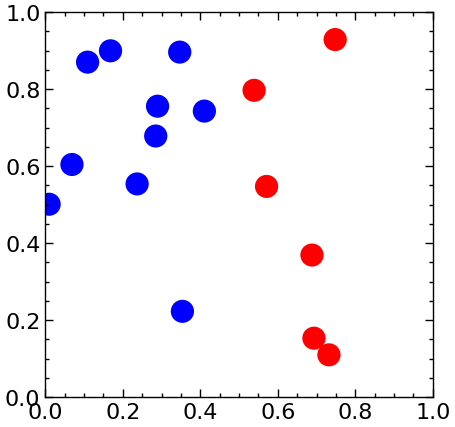

In [26]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl],rs[0][1][ixl]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Make initial animation of the simulation

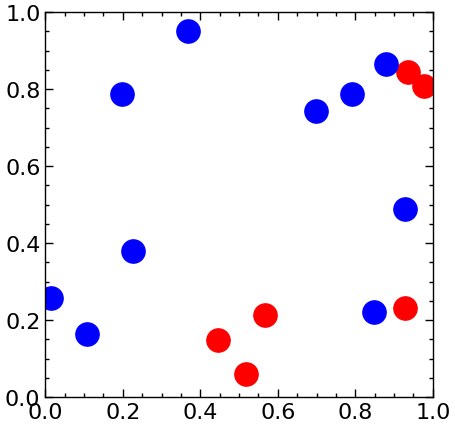

In [27]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.clear()
vmin = 0
vmax = 1
ax.set_xlim(0,1)
ax.set_ylim(0,1)
markersize = 2 * radius * ax.get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = ax.plot([], [], 'o', color='red', markersize=markersize)
blue, = ax.plot([], [], 'o', color='blue', markersize=markersize)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani3.mp4',writer=writer,dpi=100)

Now that we're sure that it works, lets make a simulation containing many more particles

In [29]:
n_particles = 10000
r = torch.rand((2,n_particles)).to(device)
ixr = r[0]>0.5 
ixl = r[0]<=0.5 
ids = torch.arange(n_particles)
ids_pairs = torch.combinations(ids,2).to(device)
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500
radius = 0.0005
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=0.000008, d_cutoff=2*radius)

Let's look at the final velocity distribution of the particles and compare it to Maxwell-Boltzmann in 2 Dimensions:

* $kT = KE_{avg} = \frac{1}{2}m\bar{v^2} \implies \boxed{\frac{m}{kT} = \frac{2}{\bar{v^2}}}$
* $\boxed{f(v) = \frac{m}{kT} v \exp\left(-\frac{m}{kT}\frac{v^2}{2} \right)}$

In [30]:
v = np.linspace(0, 2000, 1000)
a = 2/500**2
fv = a*v*np.exp(-a*v**2 / 2)

Plot the final histogram next to this curve:

Text(0, 0.5, '# Particles')

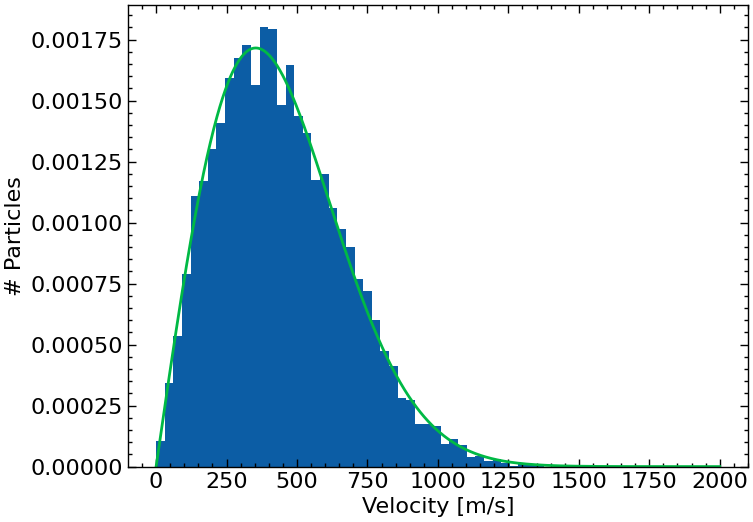

In [31]:
bins = np.linspace(0,1500,50)
plt.figure()
plt.hist(torch.sqrt(torch.sum(vs[400]**2, axis=0)).cpu(), bins=bins, density=True)
plt.plot(v,fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')

Finally, we can make an animation of the particles moving around and the histogram at the same time

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].clear()
vmin = 0
vmax = 1
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
markersize = 2 * radius * axes[0].get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = axes[0].plot([], [], 'o', color='red', markersize=markersize)
blue, = axes[0].plot([], [], 'o', color='blue', markersize=markersize)
n, bins, patches = axes[1].hist(torch.sqrt(torch.sum(vs[0]**2, axis=0)).cpu(), bins=bins, density=True)
axes[1].plot(v,fv)
axes[1].set_ylim(top=0.003)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    hist, _ = np.histogram(torch.sqrt(torch.sum(vs[i]**2, axis=0)).cpu(), bins=bins, density=True)
    for i, patch in enumerate(patches):
        patch.set_height(hist[i])
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani_gpu_10000.mp4',writer=writer,dpi=100)